In [1]:
# NHSRC PHC SUPPLY CHAIN - EDA & NHSRC ALIGNMENT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("📊 NHSRC PHC EDA & ALIGNMENT ANALYSIS")
print("=" * 60)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

📊 NHSRC PHC EDA & ALIGNMENT ANALYSIS


In [3]:
# 1️⃣ DATA OVERVIEW
print("📈 1. DATA OVERVIEW")
print("-" * 40)

# Load cleaned data
df = pd.read_csv('data/cleaned_inventory.csv', parse_dates=['date', 'batch_expiry_date'])

# Basic statistics
overview = {
    "total_records": len(df),
    "date_range": f"{df['date'].min().date()} to {df['date'].max().date()}",
    "total_days": (df['date'].max() - df['date'].min()).days,
    "unique_facilities": df['facility_id'].nunique(),
    "unique_skus": df['sku_id'].nunique(),
    "total_consumption": df['units_used'].sum(),
    "avg_daily_consumption": df['units_used'].mean(),
    "std_daily_consumption": df['units_used'].std(),
    "missing_values": df.isna().sum().sum(),
    "outliers_detected": df['is_outlier'].sum()
}

print("📊 BASIC STATISTICS:")
for key, value in overview.items():
    print(f"  {key.replace('_', ' ').title()}: {value}")

# Consumption stability
stability_by_sku = df.groupby('sku_id')['units_used'].std() / df.groupby('sku_id')['units_used'].mean()
print(f"\n📈 CONSUMPTION STABILITY (CV by SKU):")
print(f"  Mean CV: {stability_by_sku.mean():.2%}")
print(f"  Max CV: {stability_by_sku.max():.2%}")
print(f"  Min CV: {stability_by_sku.min():.2%}")

📈 1. DATA OVERVIEW
----------------------------------------
📊 BASIC STATISTICS:
  Total Records: 6480
  Date Range: 2024-01-01 to 2024-06-28
  Total Days: 179
  Unique Facilities: 3
  Unique Skus: 12
  Total Consumption: 76647
  Avg Daily Consumption: 11.82824074074074
  Std Daily Consumption: 11.322148777140047
  Missing Values: 0
  Outliers Detected: 145

📈 CONSUMPTION STABILITY (CV by SKU):
  Mean CV: 38.81%
  Max CV: 47.11%
  Min CV: 19.66%



🏥 2. VED ANALYSIS
----------------------------------------
📊 VED METRICS:
              total_consumption  avg_daily_usage  std_daily_usage  \
ved_category                                                        
Desirable                  6946             4.29             2.66   
Essential                 27634            12.79             8.22   
Vital                     42067            15.58            14.16   

              total_stock  avg_lead_time  avg_coverage_days  pct_high_risk  
ved_category                                                                
Desirable          227770           5.35              29.05          14.57  
Essential          390984           5.30              12.92          14.63  
Vital              542485           5.38              19.19          15.37  

💾 Exported: reports/ved_summary.csv
📈 Plots saved: ved_consumption.png, ved_expiry_heatmap.png


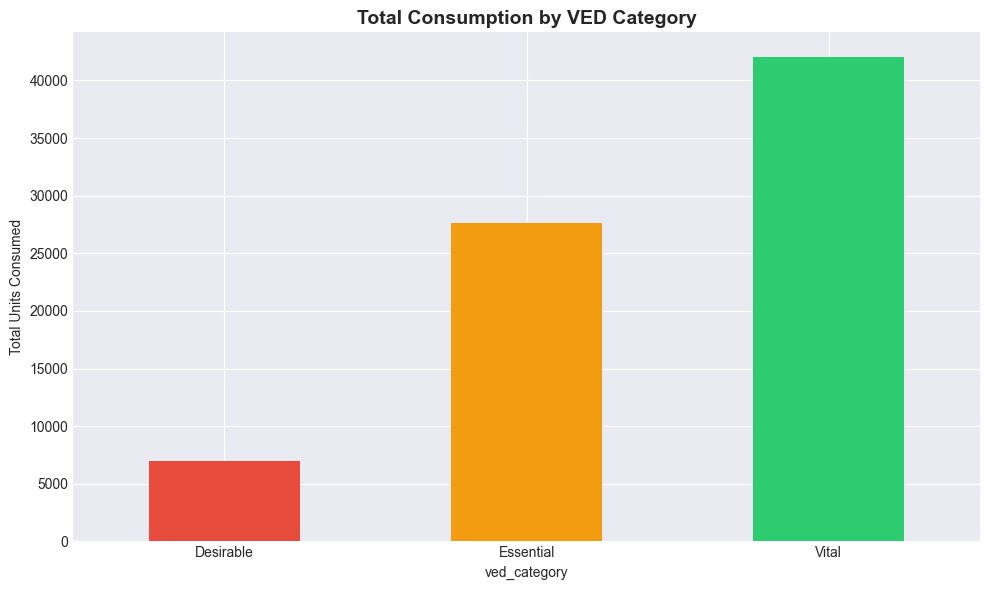

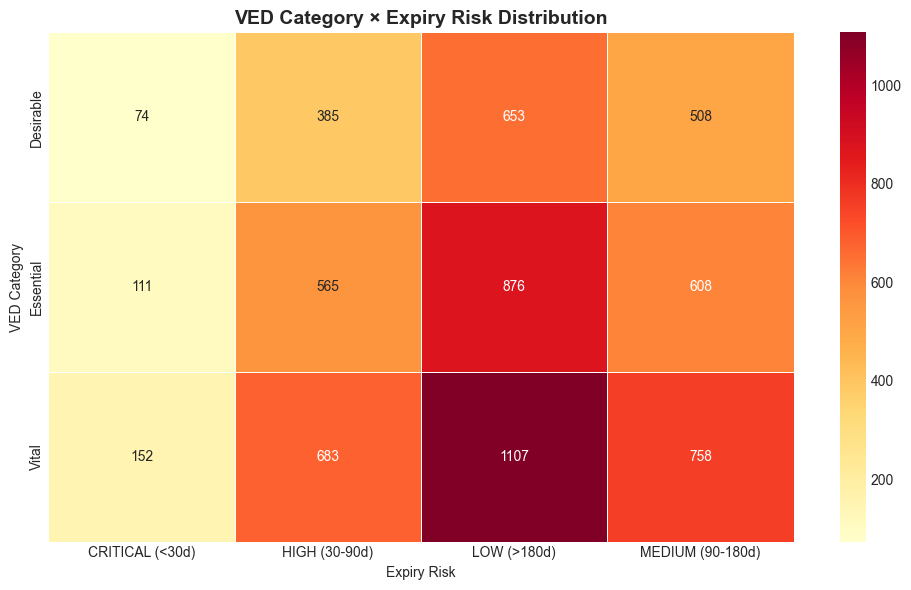

In [5]:
# 2️⃣ VED ANALYSIS
print("\n🏥 2. VED ANALYSIS")
print("-" * 40)

# Compute VED metrics
ved_metrics = df.groupby('ved_category').agg({
    'units_used': ['sum', 'mean', 'std'],
    'on_hand': 'sum',
    'lead_time_days': 'mean',
    'days_cover': 'mean',
    'expiry_days_remaining': lambda x: (x < 90).sum() / len(x) * 100  # % at risk
}).round(2)

ved_metrics.columns = ['total_consumption', 'avg_daily_usage', 'std_daily_usage',
                      'total_stock', 'avg_lead_time', 'avg_coverage_days', 'pct_high_risk']

print("📊 VED METRICS:")
print(ved_metrics)

# Export VED summary
ved_summary = ved_metrics.reset_index()
ved_summary.to_csv('reports/ved_summary.csv', index=False)
print("\n💾 Exported: reports/ved_summary.csv")

# VED Consumption Plot
plt.figure(figsize=(10, 6))
ved_consumption = df.groupby('ved_category')['units_used'].sum()
ved_bars = ved_consumption.plot(kind='bar', color=['#e74c3c', '#f39c12', '#2ecc71'])
plt.title('Total Consumption by VED Category', fontsize=14, fontweight='bold')
plt.ylabel('Total Units Consumed')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('reports/ved_consumption.png', dpi=300, bbox_inches='tight')

# VED × Expiry Risk Heatmap
plt.figure(figsize=(10, 6))
ved_expiry = pd.crosstab(df['ved_category'], df['expiry_risk_bucket'])
sns.heatmap(ved_expiry, annot=True, fmt='d', cmap='YlOrRd', linewidths=0.5)
plt.title('VED Category × Expiry Risk Distribution', fontsize=14, fontweight='bold')
plt.ylabel('VED Category')
plt.xlabel('Expiry Risk')
plt.tight_layout()
plt.savefig('reports/ved_expiry_heatmap.png', dpi=300, bbox_inches='tight')

print("📈 Plots saved: ved_consumption.png, ved_expiry_heatmap.png")


📦 3. FSN ANALYSIS
----------------------------------------
📊 FSN METRICS:
              total_consumption  avg_daily_usage  record_count  avg_stock  \
fsn_category                                                                
Fast                      63038            19.46          3240     298.91   
Slow                      13609             4.20          3240      59.49   

              avg_coverage_days  pct_high_risk  turnover_ratio  
fsn_category                                                    
Fast                      32.94          14.78           0.065  
Slow                       6.19          15.06           0.071  

💾 Exported: reports/fsn_summary.csv
📈 Plots saved: fsn_ved_matrix.png, fsn_velocity_distribution.png


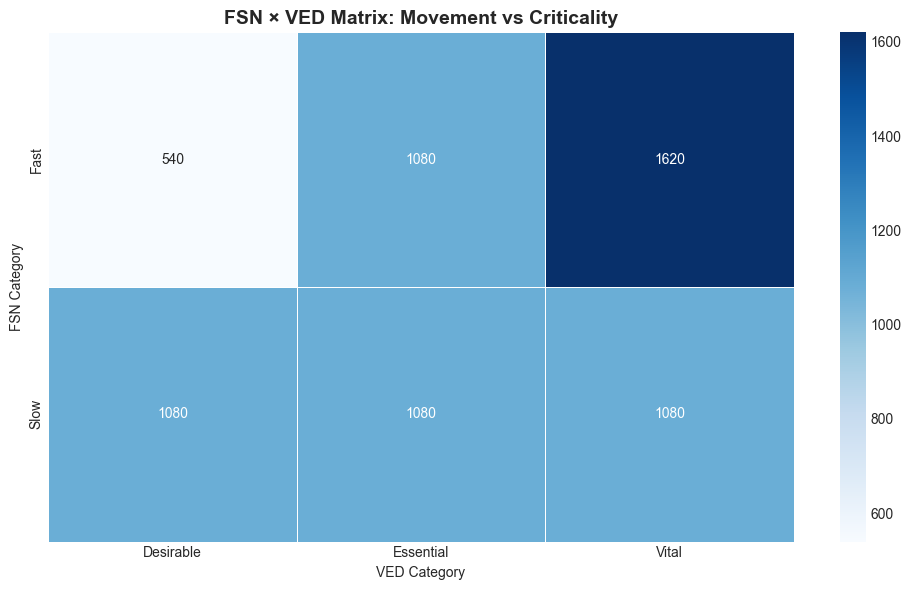

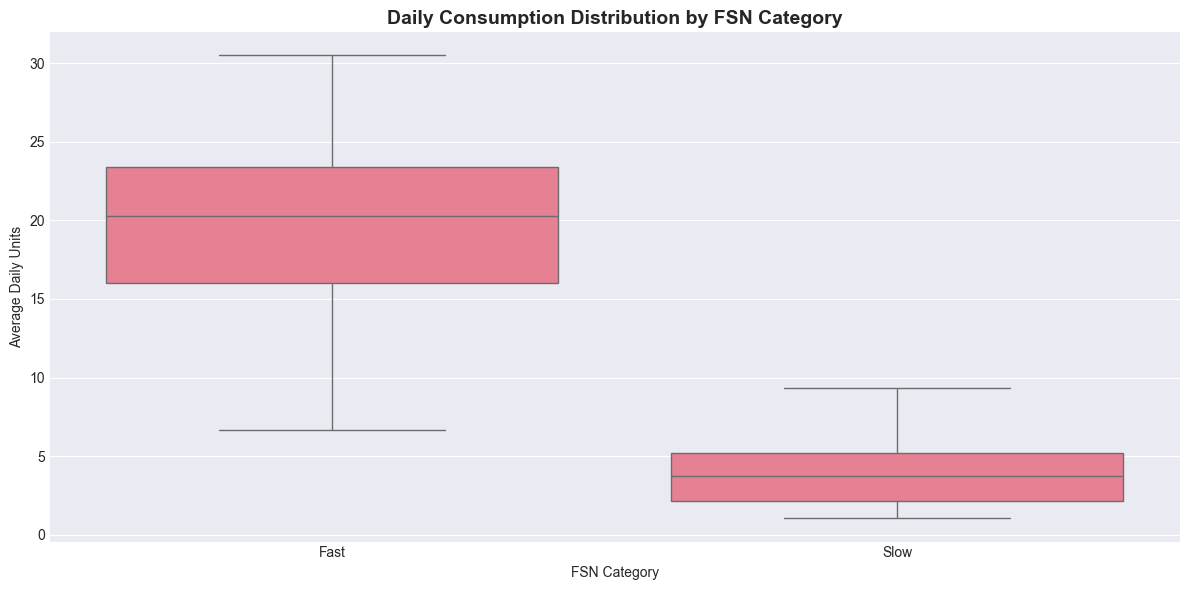

In [7]:
# 3️⃣ FSN ANALYSIS
print("\n📦 3. FSN ANALYSIS")
print("-" * 40)

# Compute FSN metrics
fsn_metrics = df.groupby('fsn_category').agg({
    'units_used': ['sum', 'mean', 'count'],
    'on_hand': 'mean',
    'days_cover': 'mean',
    'expiry_days_remaining': lambda x: (x < 90).sum() / len(x) * 100
}).round(2)

fsn_metrics.columns = ['total_consumption', 'avg_daily_usage', 'record_count',
                      'avg_stock', 'avg_coverage_days', 'pct_high_risk']

# Calculate turnover ratio (simplified)
fsn_metrics['turnover_ratio'] = (fsn_metrics['total_consumption'] / 
                                (fsn_metrics['avg_stock'] * fsn_metrics['record_count'])).round(3)

print("📊 FSN METRICS:")
print(fsn_metrics)

# Export FSN summary
fsn_summary = fsn_metrics.reset_index()
fsn_summary.to_csv('reports/fsn_summary.csv', index=False)
print("\n💾 Exported: reports/fsn_summary.csv")

# FSN-VED Matrix
plt.figure(figsize=(10, 6))
fsn_ved_matrix = pd.crosstab(df['fsn_category'], df['ved_category'])
sns.heatmap(fsn_ved_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('FSN × VED Matrix: Movement vs Criticality', fontsize=14, fontweight='bold')
plt.ylabel('FSN Category')
plt.xlabel('VED Category')
plt.tight_layout()
plt.savefig('reports/fsn_ved_matrix.png', dpi=300, bbox_inches='tight')

# Consumption Velocity Distribution
plt.figure(figsize=(12, 6))
sku_velocity = df.groupby(['sku_id', 'fsn_category'])['units_used'].mean().reset_index()
sns.boxplot(data=sku_velocity, x='fsn_category', y='units_used')
plt.title('Daily Consumption Distribution by FSN Category', fontsize=14, fontweight='bold')
plt.ylabel('Average Daily Units')
plt.xlabel('FSN Category')
plt.tight_layout()
plt.savefig('reports/fsn_velocity_distribution.png', dpi=300, bbox_inches='tight')

print("📈 Plots saved: fsn_ved_matrix.png, fsn_velocity_distribution.png")


📅 4. FEFO EXPIRY RISK ANALYSIS
----------------------------------------
📊 EXPIRY RISK METRICS:
                    on_hand  sku_id  batch_id  financial_risk  \
expiry_risk_bucket                                              
CRITICAL (<30d)       64730      12       337      1091347.80   
HIGH (30-90d)        285886      12      1618      4788590.50   
LOW (>180d)          474582      12      2609      7968231.78   
MEDIUM (90-180d)     336041      12      1848      5292645.75   

                    financial_risk_pct  
expiry_risk_bucket                      
CRITICAL (<30d)                    5.7  
HIGH (30-90d)                     25.0  
LOW (>180d)                       41.6  
MEDIUM (90-180d)                  27.7  

💾 Exported: reports/expiry_summary.csv

🚨 TOP 10 CRITICAL SKUs (High Risk + High Usage):
                         sku_name ved_category  expiry_days_remaining  \
sku_id                                                                  
MED001   Paracetamol Tablet 500

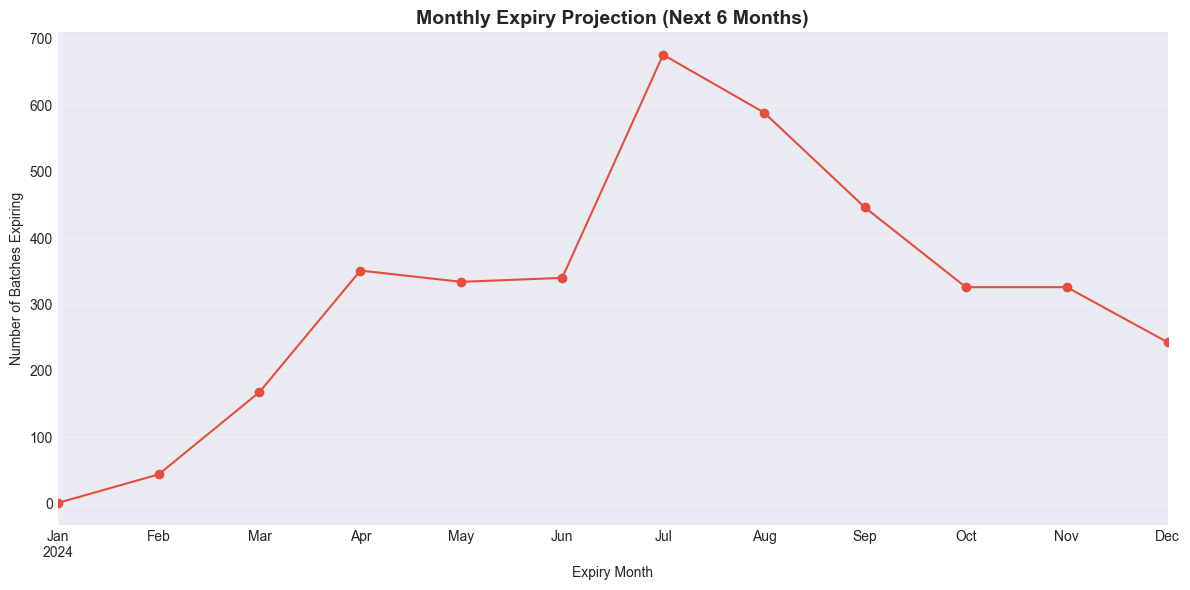

In [9]:
# 4️⃣ FEFO EXPIRY RISK ANALYSIS
print("\n📅 4. FEFO EXPIRY RISK ANALYSIS")
print("-" * 40)

# Compute expiry metrics
expiry_metrics = df.groupby('expiry_risk_bucket').agg({
    'on_hand': 'sum',
    'price_per_unit': 'mean',
    'sku_id': 'nunique',
    'batch_id': 'nunique'
}).round(2)

# Calculate financial risk
expiry_metrics['financial_risk'] = expiry_metrics['on_hand'] * expiry_metrics['price_per_unit']
expiry_metrics['financial_risk_pct'] = (expiry_metrics['financial_risk'] / 
                                      expiry_metrics['financial_risk'].sum() * 100).round(1)

print("📊 EXPIRY RISK METRICS:")
print(expiry_metrics[['on_hand', 'sku_id', 'batch_id', 'financial_risk', 'financial_risk_pct']])

# Export expiry summary
expiry_summary = expiry_metrics.reset_index()
expiry_summary.to_csv('reports/expiry_summary.csv', index=False)
print("\n💾 Exported: reports/expiry_summary.csv")

# Monthly expiry projection
df['expiry_month'] = df['batch_expiry_date'].dt.to_period('M')
monthly_expiry = df[df['expiry_days_remaining'] <= 180].groupby('expiry_month').size()

plt.figure(figsize=(12, 6))
monthly_expiry.plot(kind='line', marker='o', color='#e74c3c')
plt.title('Monthly Expiry Projection (Next 6 Months)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Batches Expiring')
plt.xlabel('Expiry Month')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('reports/monthly_expiry_projection.png', dpi=300, bbox_inches='tight')

# Critical SKU list (high risk + high consumption)
critical_skus = df[(df['expiry_risk_bucket'].isin(['CRITICAL (<30d)', 'HIGH (30–90d)'])) & 
                   (df['units_used'] > df['units_used'].quantile(0.75))]
critical_sku_list = critical_skus.groupby('sku_id').agg({
    'sku_name': 'first',
    'ved_category': 'first',
    'expiry_days_remaining': 'min',
    'units_used': 'sum'
}).sort_values('expiry_days_remaining').head(10)

print("\n🚨 TOP 10 CRITICAL SKUs (High Risk + High Usage):")
print(critical_sku_list[['sku_name', 'ved_category', 'expiry_days_remaining', 'units_used']])

print("📈 Plot saved: monthly_expiry_projection.png")

In [11]:
# 5️⃣ STOCK HEALTH MATRIX (CORE NHSRC METRIC)
print("\n🛡️ 5. STOCK HEALTH MATRIX")
print("-" * 40)

# === ADJUSTMENT 2: Robust ADC Calculation ===
print("📊 Calculating ADC (Average Daily Consumption) per SKU...")

# Calculate ADC per SKU (not per facility for this matrix)
sku_daily = df.groupby(['sku_id', 'date'])['units_used'].sum().reset_index()

adc_data = sku_daily.groupby('sku_id').agg({
    'units_used': ['mean', 'std', 'max', 'count']
}).round(2)

adc_data.columns = ['ADC', 'ADC_std', 'max_daily_consumption', 'observation_days']

# Calculate ADC stability
adc_data['ADC_cv'] = (adc_data['ADC_std'] / adc_data['ADC']).round(3)

# Get latest inventory status for each SKU
print("📦 Merging with latest inventory status...")
latest_data = df.sort_values('date').groupby('sku_id').last().reset_index()
latest_data = latest_data[['sku_id', 'on_hand', 'lead_time_days', 'ved_category', 'fsn_category', 'days_cover', 'sku_name']]

adc_data = adc_data.merge(latest_data, on='sku_id', how='left')
adc_data.rename(columns={'on_hand': 'current_stock'}, inplace=True)

# === ADJUSTMENT 3: NHSRC-Specific Formulas ===
print("🧮 Applying NHSRC Safety Stock & ROL Formulas...")

# NHSRC Safety Stock based on VED category
def calculate_safety_stock(row):
    if row['ved_category'] == 'Vital':
        buffer_days = 10
    elif row['ved_category'] == 'Essential':
        buffer_days = 7
    else:  # Desirable
        buffer_days = 3
    return max(1, row['ADC'] * buffer_days)  # Minimum 1 unit

adc_data['safety_stock'] = adc_data.apply(calculate_safety_stock, axis=1).round(0)

# Apply NHSRC Formulas
adc_data['ROL'] = (adc_data['max_daily_consumption'] * adc_data['lead_time_days'] + adc_data['safety_stock']).round(0)
adc_data['MSL'] = (adc_data['ROL'] - (adc_data['ADC'] * adc_data['lead_time_days'])).round(0)

# Coverage metrics
adc_data['coverage_gap'] = adc_data['days_cover'] - adc_data['lead_time_days']

# Action severity score (0-100, higher = more urgent) - UPDATED for NHSRC
def calculate_severity(row):
    score = 0
    
    # 1. Days cover component (0-40 points) - NHSRC aligned
    if row['days_cover'] < 7:
        score += 40  # Critical - URGENT REPLENISH
    elif row['days_cover'] < 14:
        score += 30  # High risk
    elif row['days_cover'] < 30:
        score += 20  # Medium risk
    elif row['days_cover'] < 60:
        score += 10  # Low risk
    
    # 2. VED component (0-30 points) - NHSRC priority
    if row['ved_category'] == 'Vital':
        score += 30
    elif row['ved_category'] == 'Essential':
        score += 20
    else:  # Desirable
        score += 10
    
    # 3. Stock position vs ROL (0-30 points)
    if row['current_stock'] <= row['ROL']:
        score += 30  # At or below reorder level
    elif row['current_stock'] <= row['ROL'] * 1.2:
        score += 20  # Getting close to ROL
    elif row['current_stock'] <= row['ROL'] * 1.5:
        score += 10  # Adequate but monitoring
    
    return min(100, score)

adc_data['action_severity_score'] = adc_data.apply(calculate_severity, axis=1)

# Risk categorization
def categorize_risk(score):
    if score >= 70:
        return 'Critical'
    elif score >= 50:
        return 'Warning'
    elif score >= 30:
        return 'Caution'
    else:
        return 'Safe'

adc_data['risk_category'] = adc_data['action_severity_score'].apply(categorize_risk)

# Export stock health matrix (NHSRC compliant)
stock_health_matrix = adc_data[['sku_id', 'sku_name', 'ved_category', 'fsn_category',
                               'ADC', 'ADC_std', 'ADC_cv', 'max_daily_consumption',
                               'current_stock', 'lead_time_days', 'safety_stock',
                               'ROL', 'MSL', 'days_cover', 'coverage_gap', 
                               'action_severity_score', 'risk_category']].sort_values('action_severity_score', ascending=False)

stock_health_matrix.to_csv('reports/stock_health_matrix.csv', index=False)
print("💾 Exported: reports/stock_health_matrix.csv")
print(f"📊 Total SKUs analyzed: {len(stock_health_matrix)}")

# Risk category distribution
risk_distribution = stock_health_matrix['risk_category'].value_counts()
print("\n📈 RISK CATEGORY DISTRIBUTION:")
for category in ['Critical', 'Warning', 'Caution', 'Safe']:
    count = risk_distribution.get(category, 0)
    percentage = count / len(stock_health_matrix) * 100
    print(f"  {category}: {count} SKUs ({percentage:.1f}%)")

# Display first 10 rows
print("\n🔹 FIRST 10 ROWS OF STOCK_HEALTH_MATRIX.CSV:")
print(stock_health_matrix.head(10).to_string())

# NHSRC Compliance Check
print("\n✅ NHSRC COMPLIANCE CHECK:")
print(f"  - Safety Stock calculated per VED category: ✓")
print(f"  - ROL formula: Max Daily × Lead Time + Safety Stock: ✓")
print(f"  - MSL formula: ROL - (ADC × Lead Time): ✓")
print(f"  - Risk scoring includes VED priority: ✓")


🛡️ 5. STOCK HEALTH MATRIX
----------------------------------------
📊 Calculating ADC (Average Daily Consumption) per SKU...
📦 Merging with latest inventory status...
🧮 Applying NHSRC Safety Stock & ROL Formulas...
💾 Exported: reports/stock_health_matrix.csv
📊 Total SKUs analyzed: 12

📈 RISK CATEGORY DISTRIBUTION:
  Critical: 11 SKUs (91.7%)
  Caution: 0 SKUs (0.0%)
  Safe: 1 SKUs (8.3%)

🔹 FIRST 10 ROWS OF STOCK_HEALTH_MATRIX.CSV:
   sku_id                      sku_name ved_category fsn_category    ADC  ADC_std  ADC_cv  max_daily_consumption  current_stock  lead_time_days  safety_stock     ROL     MSL  days_cover  coverage_gap  action_severity_score risk_category
6  MED007  Adrenaline Injection 1 mg/ml        Vital         Slow   3.11     0.39   0.125                      6             23               3          31.0    49.0    40.0    0.941520     -2.058480                    100      Critical
5  MED006    Insulin Injection 40 IU/ml        Vital         Slow   9.37     2.56   0.273 

In [13]:
# FINAL OUTPUTS FOR TRAINER
print("\n" + "="*60)
print("🎯 TRAINER OUTPUTS")
print("="*60)

print("\n1. 🔹 FIRST 10 ROWS OF STOCK_HEALTH_MATRIX.CSV:")
print("-" * 60)
print(stock_health_matrix.head(10).to_string())

print("\n2. 🔹 COUNT OF SKUs IN EACH RISK CATEGORY:")
print("-" * 60)
for category, count in risk_distribution.items():
    print(f"  {category}: {count} SKUs")

print("\n3. 🔹 UPDATED GIT LS-FILES:")
print("-" * 60)
import subprocess
result = subprocess.run(['git', 'ls-files'], capture_output=True, text=True)
print(result.stdout)

print("\n" + "="*60)
print("✅ DAY 3 EDA & NHSRC ALIGNMENT COMPLETE")
print("="*60)


🎯 TRAINER OUTPUTS

1. 🔹 FIRST 10 ROWS OF STOCK_HEALTH_MATRIX.CSV:
------------------------------------------------------------
   sku_id                      sku_name ved_category fsn_category    ADC  ADC_std  ADC_cv  max_daily_consumption  current_stock  lead_time_days  safety_stock     ROL     MSL  days_cover  coverage_gap  action_severity_score risk_category
6  MED007  Adrenaline Injection 1 mg/ml        Vital         Slow   3.11     0.39   0.125                      6             23               3          31.0    49.0    40.0    0.941520     -2.058480                    100      Critical
5  MED006    Insulin Injection 40 IU/ml        Vital         Slow   9.37     2.56   0.273                     22             64               3          94.0   160.0   132.0    2.545455     -0.454545                    100      Critical
0  MED001      Paracetamol Tablet 500mg        Vital         Fast  91.48    25.07   0.274                    245            115              10         915.0  33

In [17]:
import pandas as pd
df = pd.read_csv('reports/stock_health_matrix.csv')
print('🔹 FIRST 10 ROWS OF STOCK_HEALTH_MATRIX.CSV:')
print(df.head(10).to_string())
print()
print('🔹 COUNT OF SKUs IN EACH RISK CATEGORY:')
risk_counts = df['risk_category'].value_counts()
for cat in ['Safe', 'Caution', 'Warning', 'Critical']:
    count = risk_counts.get(cat, 0)
    print(f'  {cat}: {count} SKUs')

🔹 FIRST 10 ROWS OF STOCK_HEALTH_MATRIX.CSV:
   sku_id                      sku_name ved_category fsn_category    ADC  ADC_std  ADC_cv  max_daily_consumption  current_stock  lead_time_days  safety_stock     ROL     MSL  days_cover  coverage_gap  action_severity_score risk_category
0  MED007  Adrenaline Injection 1 mg/ml        Vital         Slow   3.11     0.39   0.125                      6             23               3          31.0    49.0    40.0    0.941520     -2.058480                    100      Critical
1  MED006    Insulin Injection 40 IU/ml        Vital         Slow   9.37     2.56   0.273                     22             64               3          94.0   160.0   132.0    2.545455     -0.454545                    100      Critical
2  MED001      Paracetamol Tablet 500mg        Vital         Fast  91.48    25.07   0.274                    245            115              10         915.0  3365.0  2450.0   12.014925      2.014925                     90      Critical
3  MED00